# Data description & Problem statement: 
Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues. 
Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information. This is a Regression problem. Dataset has 17389 rows and 16 variables.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training and test part for the final evaluation of model)
   #  Model Training:
- Train the Deep Neural Network model by Keras/Tensorflow
   # Model Evaluation: 
- Evaluate the Neural Network model on Test Dataset, by calculating:
     - r2 (determination factor)
     - Lift chart
     - RMSE 
     - Box-plot for prediction Vs. actual values 
     - Distribution plot of error/residuals

In [1]:
import keras
import sklearn
import tensorflow as tf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, preprocessing
import random as rn
%matplotlib inline

import os
os.environ['PYTHONHASHSEED'] = '0'

# for the reproducable results:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
df=pd.read_csv('hour.csv', parse_dates=['dteday'])

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null datetime64[ns]
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(12)
memory usage: 2.3 MB


In [3]:
df.drop(["yr", "mnth", "weekday"], axis=1, inplace=True)
df.set_index(['instant'], inplace=True)

In [4]:
# We need to convert datetime to numeric for training.
# Let's extract key features into separate numeric columns
def add_features(df):
    df['year'] = df['dteday'].dt.year
    df['month'] = df['dteday'].dt.month
    df['day'] = df['dteday'].dt.day
    df['dayofweek'] = df['dteday'].dt.dayofweek

add_features(df)

In [5]:
df.head(3)

,dteday,season,hr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,day,dayofweek
instant,,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,0,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011,1,1,5
2,2011-01-01,1,1,0,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011,1,1,5
3,2011-01-01,1,2,0,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011,1,1,5


In [6]:
X=df.drop(['casual', 'registered', 'cnt', 'dteday'], axis=1)
y=np.log1p(df['cnt'])

# Re-scaling & Polynomial Interactions:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

scalor_X=MinMaxScaler().fit(pd.DataFrame(X))
X_train=scalor_X.transform(pd.DataFrame(X_train))
X_test=scalor_X.transform(pd.DataFrame(X_test))

scaler_y=MinMaxScaler().fit(pd.DataFrame(y))
y_train=scaler_y.transform(pd.DataFrame(y_train))
y_test=scaler_y.transform(pd.DataFrame(y_test))

In [7]:
# Keras Neural Networks: ___________________
n_input=X.shape[1]

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

model=Sequential()
model.add(Dense(30, activation="relu", input_shape=(n_input, )))
#model.add(Dropout(0.1))
model.add(Dense(80, activation="linear"))
model.add(Dropout(0.1))
model.add(Dense(30, activation="relu"))
model.add(Dense(1))


model.compile(optimizer="adam", loss="mean_squared_error")

monitor=EarlyStopping(monitor='loss', min_delta=0.001, patience=200, mode="auto")
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

history=model.fit(X_train,y_train, epochs=200, batch_size=8, validation_data=(X_test, y_test), callbacks=[monitor, checkpointer],  verbose=0)
model.load_weights('best_weights.hdf5') # load weights from best model

model.load_weights('best_weights.hdf5') # load weights from best model
print("Training R^2 score = ", metrics.r2_score(y_train, model.predict(X_train)),"\n")
print("Test R^2 score = ", metrics.r2_score(y_test, model.predict(X_test)) ,"\n")

Training R^2 score =  0.9566088272612884 

Test R^2 score =  0.9519360750876602 



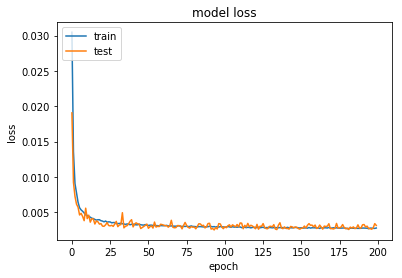

In [8]:
# list all data in history
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

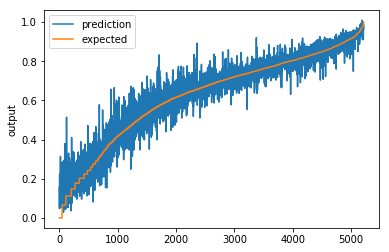

In [9]:
# Plot the Lift Chart:

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
        plt.plot(t['pred'].tolist(),label='prediction')
        plt.plot(t['y'].tolist(),label='expected')
        plt.ylabel('output')
    plt.legend()
    plt.show()

pred=model.predict(X_test)
chart_regression(pred.flatten(), np.array(y_test), sort=True)

In [10]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_inv=scaler_y.inverse_transform(pd.DataFrame(pred))
y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(np.expm1(y_test_inv), np.expm1(pred_inv)))
print('Test rmse: ', rmse)

Test rmse:  48.2322845501268


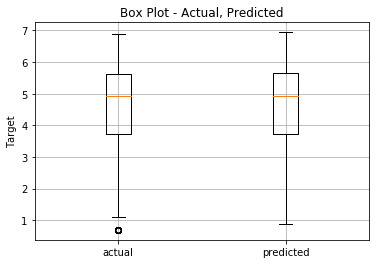

In [11]:
plt.boxplot([y_test_inv.ravel(), pred_inv.ravel()], labels=['actual','predicted'])
plt.title('Box Plot - Actual, Predicted')
plt.ylabel('Target')
plt.grid(True)

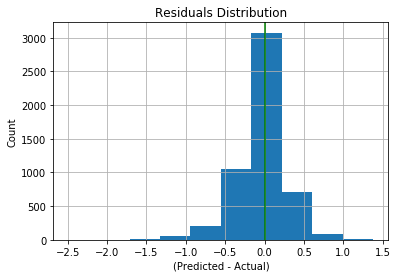

In [12]:
# Over prediction and Under Prediction needs to be balanced:
# Training Data Residuals
residuals = y_test_inv.ravel()-pred_inv.ravel()

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
plt.show()